In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import math
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import warnings
warnings.filterwarnings('ignore')

In [2]:
winereviews = pd.read_csv('winemag-data-130k-v2.csv').drop('Unnamed: 0',axis=1)

# visualizations 1 & 2

Text(0.5, 1.0, 'Correlation between Points and Price')

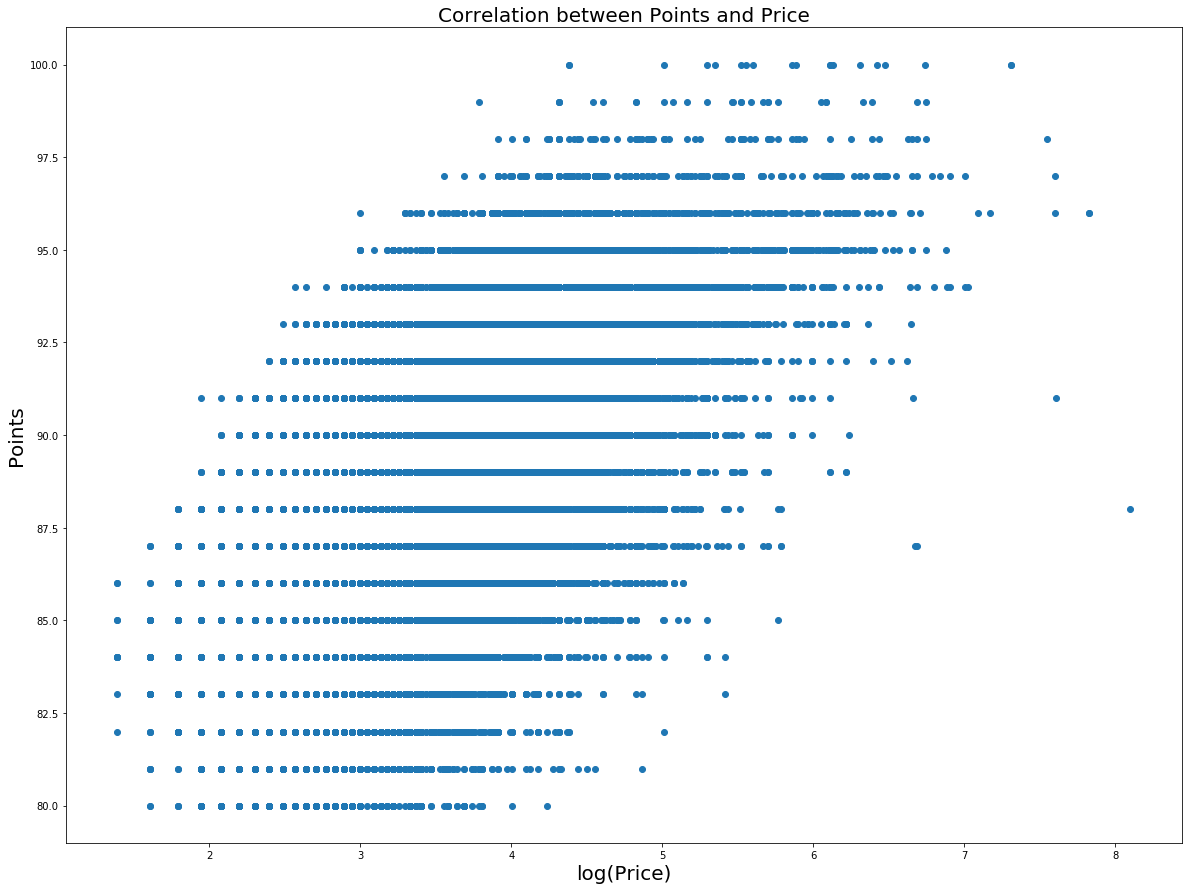

In [3]:
fig = plt.figure(figsize=(20,15))
x = np.log(winereviews.price)
y = winereviews.points
plt.scatter(x,y)
plt.xlabel('log(Price)', fontsize=20)
plt.ylabel('Points', fontsize=20)
plt.title('Correlation between Points and Price',fontsize=20)

The does exist a corelation between the points given to the wine and the logof the price og the wine. A linear combination of the variables can give a straight line but that line does not fit the data. But one trend is that greater the points, greater is the price of wine. To see a relationship between two quantitative variables, I have chosen a scatter plot. The plot uses points as the mark to represent the corelation and position as a channel to represen the trend.

Text(0.5, 1.0, 'Distribution of points in top 10 reviewed wines')

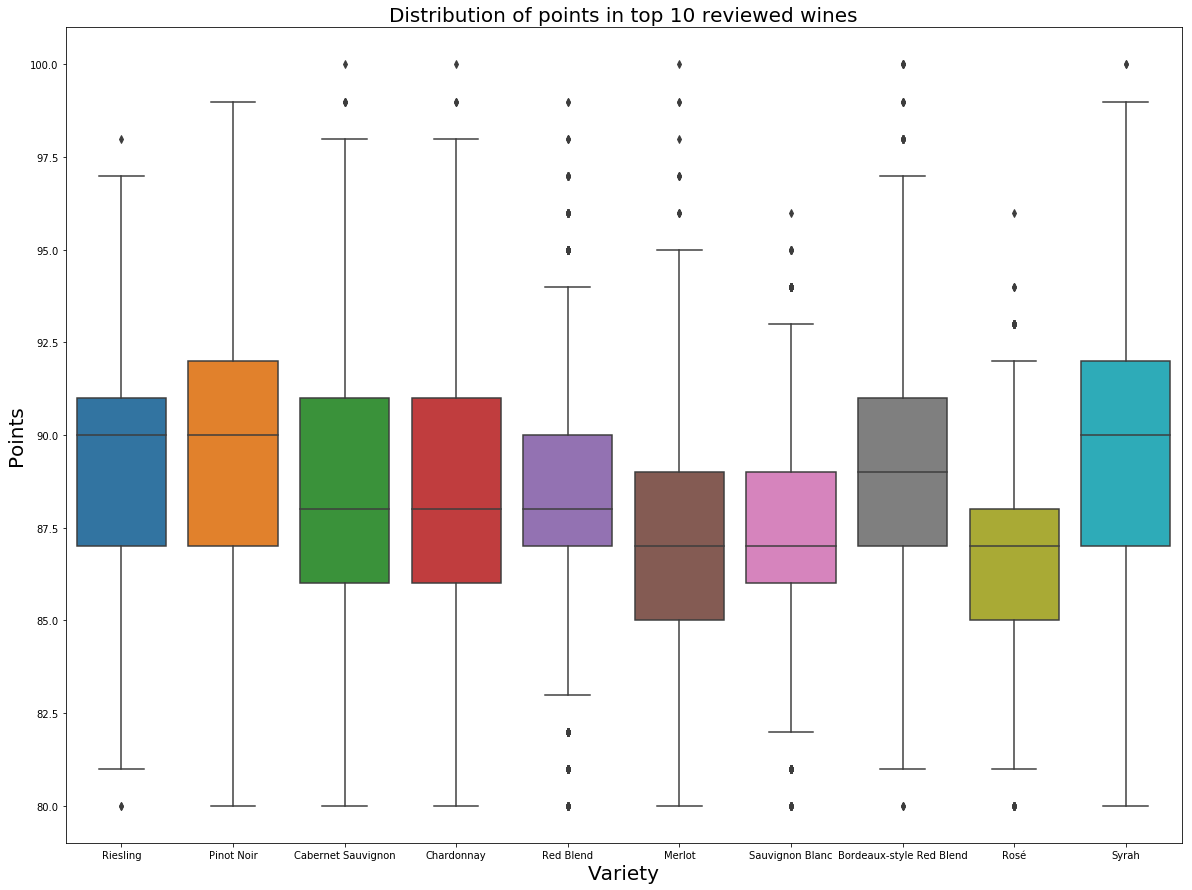

In [4]:
fig = plt.figure(figsize=(20,15))
top_reviewed_wines = winereviews.variety.value_counts().head(10)
points_top_reviewed_wines = winereviews[winereviews.variety.isin(top_reviewed_wines.index)]
x = points_top_reviewed_wines.variety
y = points_top_reviewed_wines.points
sns.boxplot(x,y)
plt.xlabel('Variety', fontsize=20)
plt.ylabel('Points', fontsize=20)
plt.title('Distribution of points in top 10 reviewed wines',fontsize=20)

The plot shows the distribution of points of the top 10 variety of wines that have maximim number of reviews. This plot is basically to compare the top reviewed wines and checking out their range and their medians. I have chosen a box plot to show the distributions of each variety. Boxes and lines are the marks to represent the distributions and position, color and area are the channels to show the points distribution and distinguish between varieties. 

# Data PreProcessing

In [ ]:
winereviews=winereviews.drop(['taster_name','taster_twitter_handle'], axis = 1)
winereviews=winereviews.drop_duplicates(['description','title'])
winereviews=winereviews.dropna(subset=['price'])
winereviews=winereviews.reset_index(drop=True)


In [ ]:
#list(winereviews)
#winereviews["test"] = winereviews["country"] + " " + winereviews["description"] + " " 
#+ winereviews["designation"] + " " + winereviews["province"] + " " + winereviews["region_1"]
#+ " " + winereviews["region_2"] + " " + winereviews["title"] + " " + winereviews["winery"]

winereviews["text"] = winereviews["country"] + " " + winereviews["description"] + " " + winereviews["designation"] + " " + winereviews["province"] + " " + winereviews["region_1"] +  " " + winereviews["region_2"] + " " + winereviews["title"] + " " + winereviews["winery"]
winereviews = winereviews.fillna(" ")
X = winereviews.drop(['country',"description",'designation','points','province','region_1','region_2','title', 'variety','winery'], axis = 1)
y = winereviews.variety
X=X.fillna(-1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [ ]:
#Scale the features which have continous features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
num_cols = X_train.columns[X_train.dtypes.apply(lambda c: np.issubdtype(c, np.float64))]
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

extras = ['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}', 'cab',"%"]
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
stop.update(extras)

In [ ]:
from scipy.sparse import hstack

vect = TfidfVectorizer(stop_words = stop)
X_train_dtm = vect.fit_transform(X_train.text)

price = X_train.price.values[:,None]
X_train_dtm = hstack((X_train_dtm, price))
X_test_dtm = vect.transform(X_test.text)
price_test = X_test.price.values[:,None]
X_test_dtm = hstack((X_test_dtm, price_test))

In [ ]:
print(X_train_dtm.shape)

In [ ]:
win = {}
win1 = {}
y = []
count = 0
for w in y_train:
    if(w not in win.keys()):
        win[w] = count
        win1[count] = w
        count+=1
    y.append(win[w])

In [ ]:
from sklearn.linear_model import LinearRegression
  
y = y_train == z    
reg = LinearRegression().fit(X_train_dtm, y)
pre = reg.predict(X_test_dtm)

predicted = []
for w in pre:
    predicted.append(win1[w])
from sklearn.metrics import accuracy_score
print('Accuracy Score:',accuracy_score(y_test, predicted)*100,"%")

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=20000, max_depth=2,
                             random_state=0)
clf.fit(X_train_dtm, y_train)

In [ ]:
pre = clf.predict(X_test_dtm)

In [ ]:
from sklearn.metrics import accuracy_score
print('Accuracy Score:',accuracy_score(y_test, pre)*100,"%")